Création de l'architecture du modèle PPO.
Chargement des poids du modèle depuis : ppo_minigrid_model.weights.h5

Démarrage de l'entraînement PPO sur MiniGrid-Empty-8x8-v0
Logs TensorBoard: tensorboard --logdir logs/mini_grid/20250801-130639
------------------------------------------------------------
  -> Episode 1: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 2: VICTOIRE! Reward: 0.909, Pas: 26
  -> Episode 3: VICTOIRE! Reward: 0.866, Pas: 38
  -> Episode 4: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 5: VICTOIRE! Reward: 0.873, Pas: 36
  -> Episode 6: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 7: VICTOIRE! Reward: 0.877, Pas: 35
  -> Episode 8: VICTOIRE! Reward: 0.944, Pas: 16
  -> Episode 9: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 10: VICTOIRE! Reward: 0.944, Pas: 16
Episode 10/150 | Reward moyen (10 ep): 0.92 | Victoires (10 ep): 10/10
  -> Episode 11: VICTOIRE! Reward: 0.944, Pas: 16
  -> Episode 12: VICTOIRE! Reward: 0.891, Pas: 31
  -> Episode 13: VICTOIRE! Reward: 0

2025-08-01 13:27:23.278048: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  -> Episode 123: VICTOIRE! Reward: 0.698, Pas: 86
  -> Episode 124: VICTOIRE! Reward: 0.866, Pas: 38
  -> Episode 126: VICTOIRE! Reward: 0.729, Pas: 77
  -> Episode 127: VICTOIRE! Reward: 0.719, Pas: 80
  -> Episode 128: VICTOIRE! Reward: 0.845, Pas: 44
  -> Episode 129: VICTOIRE! Reward: 0.873, Pas: 36
  -> Episode 130: VICTOIRE! Reward: 0.905, Pas: 27
Episode 130/150 | Reward moyen (10 ep): 0.70 | Victoires (10 ep): 9/10
  -> Episode 131: VICTOIRE! Reward: 0.926, Pas: 21
  -> Episode 132: VICTOIRE! Reward: 0.940, Pas: 17
  -> Episode 133: VICTOIRE! Reward: 0.923, Pas: 22
  -> Episode 134: VICTOIRE! Reward: 0.933, Pas: 19
  -> Episode 135: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 136: VICTOIRE! Reward: 0.940, Pas: 17
  -> Episode 137: VICTOIRE! Reward: 0.937, Pas: 18
  -> Episode 138: VICTOIRE! Reward: 0.859, Pas: 40
  -> Episode 139: VICTOIRE! Reward: 0.891, Pas: 31
  -> Episode 140: VICTOIRE! Reward: 0.940, Pas: 17
Episode 140/150 | Reward moyen (10 ep): 0.92 | Victoires (10 e

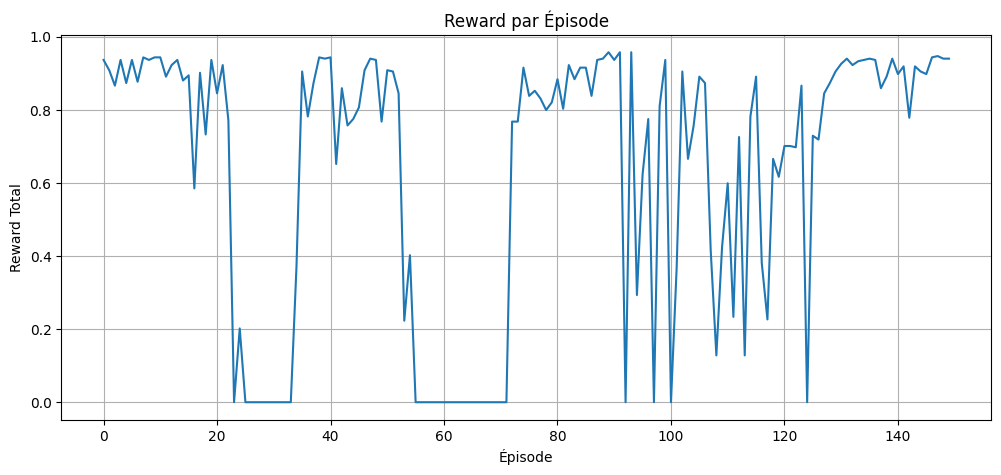


Test final du modèle (5 tentatives)
----------------------------------------
Test 1: VICTOIRE en 41 pas!
Test 2: VICTOIRE en 36 pas!
Test 3: VICTOIRE en 20 pas!
Test 4: VICTOIRE en 26 pas!
Test 5: VICTOIRE en 27 pas!
----------------------------------------
Score final: 5/5 victoires


In [13]:
import tensorflow as tf
import numpy as np
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import datetime
import os

# Configuration
env_name = "MiniGrid-Empty-8x8-v0"
episodes = 150
gamma = 0.99  # Facteur de discount
clip_ratio = 0.2  # Ratio de clipping pour PPO
learning_rate = 0.0003 # Taux d'apprentissage unifié
train_epochs = 10  # Nombre d'époques d'entraînement par batch
gae_lambda = 0.95  # Lambda pour le Generalized Advantage Estimation
batch_size = 64
model_path = 'ppo_minigrid_model.weights.h5'

# Coefficients pour la perte combinée
value_coeff = 0.5
entropy_coeff = 0.01

# --- Environnement ---
env = gym.make(env_name, render_mode="rgb_array")
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

state_shape = env.observation_space.shape
action_shape = env.action_space.n

# --- TensorBoard ---
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/mini_grid/{current_time}"


# --- Modèle Actor-Critic pour PPO ---
def create_actor_critic_model():
    """Crée un modèle avec deux têtes : une pour l'acteur (politique) et une pour le critique (valeur)."""
    input_layer = tf.keras.layers.Input(shape=state_shape)
    normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

    # Base convolutionnelle partagée
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(normalized)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(conv1)
    flattened = tf.keras.layers.Flatten()(conv2)

    # Couche dense partagée
    shared_dense = tf.keras.layers.Dense(128, activation='relu')(flattened)

    # Tête de l'Acteur (Politique)
    policy_logits = tf.keras.layers.Dense(action_shape, name='policy_logits')(shared_dense)

    # Tête du Critique (Valeur)
    value_output = tf.keras.layers.Dense(1, name='value')(shared_dense)

    model = tf.keras.Model(inputs=input_layer, outputs=[policy_logits, value_output])

    return model

# --- Agent PPO ---
class PPOAgent:
    def __init__(self, weights_file_path=None):
        """Initialise l'agent. Crée la structure du modèle, puis charge les poids si un fichier existe."""
        print("Création de l'architecture du modèle PPO.")
        self.model = create_actor_critic_model()

        if weights_file_path and os.path.exists(weights_file_path):
            print(f"Chargement des poids du modèle depuis : {weights_file_path}")
            self.model.load_weights(weights_file_path)
        else:
            print("Initialisation avec de nouveaux poids.")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.summary_writer = tf.summary.create_file_writer(log_dir)

    def select_action(self, state):
        """Sélectionne une action en se basant sur la politique actuelle."""
        logits, _ = self.model(np.expand_dims(state, 0), training=False)
        action = tf.random.categorical(logits, 1)[0, 0].numpy()
        return action

    def compute_advantages_and_returns(self, rewards, values, dones):
        """Calcule les avantages et les retours en utilisant GAE (Generalized Advantage Estimation)."""
        advantages = np.zeros_like(rewards, dtype=np.float32)
        last_advantage = 0

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
            last_advantage = delta + gamma * gae_lambda * (1 - dones[t]) * last_advantage
            advantages[t] = last_advantage

        returns = advantages + values[:-1]
        return advantages, returns

    @tf.function
    def train_step(self, states, actions, old_probs, advantages, returns):
        """Effectue une seule étape d'entraînement en utilisant une perte combinée."""
        with tf.GradientTape() as tape:
            policy_logits, values = self.model(states, training=True)
            values = tf.squeeze(values)

            action_masks = tf.one_hot(actions, action_shape)
            log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(policy_logits), axis=1)

            ratio = tf.exp(log_probs - old_probs)
            clipped_ratio = tf.clip_by_value(ratio, 1 - clip_ratio, 1 + clip_ratio)

            policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
            value_loss = tf.reduce_mean(tf.square(returns - values))
            entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.nn.softmax(policy_logits), logits=policy_logits))

            total_loss = policy_loss + value_coeff * value_loss - entropy_coeff * entropy

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return total_loss, policy_loss, value_loss, entropy

    def train(self, states, actions, rewards, dones, values, episode):
        """Orchestre la boucle d'entraînement PPO et log les résultats."""
        advantages, returns = self.compute_advantages_and_returns(rewards, values, dones)

        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        logits, _ = self.model(np.array(states[:-1]), training=False)
        action_masks = tf.one_hot(actions, action_shape)
        old_log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(logits), axis=1)

        dataset = tf.data.Dataset.from_tensor_slices((states[:-1], actions, old_log_probs, advantages, returns))
        dataset = dataset.shuffle(buffer_size=len(states)).batch(batch_size)

        total_loss_avg, policy_loss_avg, value_loss_avg, entropy_avg = [], [], [], []

        for _ in range(train_epochs):
            for batch in dataset:
                s_batch, a_batch, op_batch, adv_batch, r_batch = batch
                t_loss, p_loss, v_loss, ent = self.train_step(s_batch, a_batch, op_batch, adv_batch, r_batch)
                total_loss_avg.append(t_loss)
                policy_loss_avg.append(p_loss)
                value_loss_avg.append(v_loss)
                entropy_avg.append(ent)

        # Log des pertes moyennes pour cet épisode sur TensorBoard
        with self.summary_writer.as_default():
            tf.summary.scalar('total_loss', np.mean(total_loss_avg), step=episode)
            tf.summary.scalar('policy_loss', np.mean(policy_loss_avg), step=episode)
            tf.summary.scalar('value_loss', np.mean(value_loss_avg), step=episode)
            tf.summary.scalar('entropy', np.mean(entropy_avg), step=episode)


# --- Boucle d'entraînement principale ---
agent = PPOAgent(model_path)
reward_history = []
success_count = 0

print(f"\nDémarrage de l'entraînement PPO sur {env_name}")
print(f"Logs TensorBoard: tensorboard --logdir {log_dir}")
print("-" * 60)

for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0

    states, actions, rewards, dones, values = [], [], [], [], []

    done = False
    steps = 0
    while not done and steps < 250:
        action = agent.select_action(state)

        _, value = agent.model(np.expand_dims(state, 0), training=False)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        values.append(tf.squeeze(value).numpy())

        state = next_state
        episode_reward += reward
        steps += 1

    _, last_value = agent.model(np.expand_dims(state, 0), training=False)
    values.append(tf.squeeze(last_value).numpy())

    states.append(state)

    # Entraîner l'agent et passer le numéro de l'épisode pour les logs
    agent.train(np.array(states), np.array(actions), np.array(rewards), np.array(dones), np.array(values), episode)

    reward_history.append(episode_reward)
    # Log immédiat en cas de victoire
    if reward > 0.5:
        success_count += 1
        print(f"  -> Episode {episode+1}: VICTOIRE! Reward: {episode_reward:.3f}, Pas: {steps}")

    # Log de résumé tous les 10 épisodes
    if (episode + 1) % 10 == 0:
        last_10_rewards = reward_history[-10:]
        avg_reward = np.mean(last_10_rewards)
        successes_in_window = sum(1 for r in last_10_rewards if r > 0.5)

        print(f"Episode {episode+1}/{episodes} | Reward moyen (10 ep): {avg_reward:.2f} | Victoires (10 ep): {successes_in_window}/10")

# --- Fin de l'entraînement et résultats ---
print("\n" + "="*60)
print("Entraînement terminé!")
agent.model.save_weights(model_path)
print(f"Poids du modèle sauvegardés dans: {model_path}")
print(f"Total des victoires: {success_count}/{episodes} ({100*success_count/episodes:.1f}%)")
print("="*60)

# Affichage des graphiques
plt.figure(figsize=(12, 5))
plt.plot(reward_history)
plt.title('Reward par Épisode')
plt.xlabel('Épisode')
plt.ylabel('Reward Total')
plt.grid(True)
plt.show()

# Test final du modèle
print("\nTest final du modèle (5 tentatives)")
print("-" * 40)
test_successes = 0
for i in range(5):
    state, _ = env.reset()
    done = False
    steps = 0
    while not done and steps < 250:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        steps += 1
    if reward > 0.5:
        test_successes += 1
        print(f"Test {i+1}: VICTOIRE en {steps} pas!")
    else:
        print(f"Test {i+1}: Échec après {steps} pas")
print("-" * 40)
print(f"Score final: {test_successes}/5 victoires")

env.close()
